In [1]:
import keras
from keras import layers
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2025-11-07 22:13:43.388745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762550023.423010  176566 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762550023.434152  176566 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762550023.482903  176566 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762550023.482980  176566 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762550023.482985  176566 computation_placer.cc:177] computation placer alr

# Tell the time network
## Final model using periodic target function

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Setup

In [3]:
X = np.load('A1_data_150/images.npy')
X = X/255
y = np.load('A1_data_150/labels.npy')

y_min = np.array([i *60 +j for i,j in y])
y_reg = np.array([[np.sin((2*np.pi*i)/720),np.cos((2*np.pi*i)/720)] for i in y_min])

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X,y_reg,test_size=0.1) 

## Model

In [4]:
model = keras.Sequential()
shape = X_reg_train.shape[1:]
input_shape = shape + (1,)

In [5]:
model.add(layers.Conv2D(filters=16,kernel_size=(5,5),input_shape = input_shape))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(filters=32, kernel_size=(5,5)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.08))

model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.08))

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.08))

model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.08))

model.add(layers.Dense(2, activation="linear"))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss="mse", metrics=["mae"])

/home/jaspe/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762550030.814243  176566 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:07:00.0, compute capability: 8.6


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 16)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 67, 67, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,673,826 (25.46 MB)

 Trainable params: 6,673,698 (25.46 MB)

 Non-trainable params: 128 (512.00 B)

In [7]:
hist = model.fit(
    X_reg_train,y_reg_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32
)

Epoch 1/100


I0000 00:00:1762550037.732388  176649 service.cc:152] XLA service 0x733d90002e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762550037.732428  176649 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-11-07 22:13:57.785057: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762550038.134661  176649 cuda_dnn.cc:529] Loaded cuDNN version 90101


  7/456 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 8.6846 - mae: 1.9483 

I0000 00:00:1762550043.572489  176649 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


456/456 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2695 - mae: 0.7948

2025-11-07 22:14:13.386153: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_117_0', 44 bytes spill stores, 44 bytes spill loads

2025-11-07 22:14:13.759773: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_117', 484 bytes spill stores, 484 bytes spill loads

2025-11-07 22:14:14.151517: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_131', 4 bytes spill stores, 4 bytes spill loads

2025-11-07 22:14:14.515394: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_131', 12 bytes spill stores, 12 bytes spill loads

2025-11-07 22:14:17.233018: I external/loc

456/456 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - loss: 0.6838 - mae: 0.6786 - val_loss: 0.5084 - val_mae: 0.6357
Epoch 2/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.4761 - mae: 0.6111 - val_loss: 0.4959 - val_mae: 0.6175
Epoch 3/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3962 - mae: 0.5376 - val_loss: 0.3794 - val_mae: 0.5313
Epoch 4/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3362 - mae: 0.4868 - val_loss: 0.3114 - val_mae: 0.4523
Epoch 5/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2829 - mae: 0.4374 - val_loss: 0.2499 - val_mae: 0.4067
Epoch 6/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2342 - mae: 0.3900 - val_loss: 0.2583 - val_mae: 0.3961
Epoch 7/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1956 - mae: 0.3504 - val_loss: 0.3668 - val_mae: 0.4863
Epoch 8/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1613 - mae: 0.3136 - val_loss: 0.1509 - val_mae: 0.2952
Epoch 9/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/ste

## Evaluation

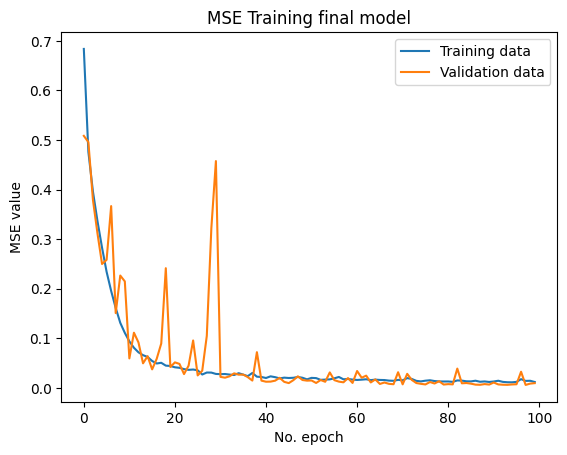

In [8]:
plt.plot(hist.history['loss'], label='Training data')
plt.plot(hist.history['val_loss'], label='Validation data')
plt.title('MSE Training final model')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [11]:
def decode_target_vals(y):
    angles_pred = np.arctan2(y[:, 0], y[:, 1])
    decoded = (angles_pred / (2 * np.pi)) * 720
    return (decoded+720)%720

y_reg_pred = model.predict(X_reg_test)
y_reg_test = decode_target_vals(y_reg_test)
y_reg_pred = decode_target_vals(y_reg_pred)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [12]:
error = np.abs(y_reg_pred - y_reg_test)
error = np.minimum(error, 720 - error)
mae = np.mean(error)
print("Mean Absolute Error (in minutes):", mae)

Mean Absolute Error (in minutes): 9.884926825629336
